In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [2]:
#reading in the csv file we previously created
all_data_basic = pd.read_csv("total_data.csv")
all_data_basic

,date,open,high,low,close,volume,symbol
0,2020-02-26,149.57,151.82,148.09,148.96,5104378.0,MMM
1,2020-02-25,153.31,153.44,145.97,146.85,5262375.0,MMM
2,2020-02-24,154.45,154.71,152.22,152.55,3635549.0,MMM
3,2020-02-21,158.33,158.59,156.12,156.93,3535306.0,MMM
4,2020-02-20,159.00,161.39,158.50,158.56,3274479.0,MMM
...,...,...,...,...,...,...,...
2300276,2013-02-07,31.00,32.73,31.00,32.00,3800800.0,ZTS
2300277,2013-02-06,30.98,31.43,30.75,31.03,2126100.0,ZTS
2300278,2013-02-05,31.25,31.98,30.85,31.04,5013200.0,ZTS
2300279,2013-02-04,31.09,31.99,30.76,31.02,7695400.0,ZTS


In [3]:
#makes a new column that is positive if there was a gain and negative if there was a loss
all_data_basic['as_coin_flip'] = all_data_basic['close'] - all_data_basic['open']
#encodes positive returns as a 1 and negative returns as a 0 to simulate flipping a coin
all_data_basic['as_coin_flip'] = all_data_basic['as_coin_flip'].apply(lambda x: 1 if x > 0 else 0)
all_data_basic['as_coin_flip'].mean()

0.5026546756678858

In [4]:
#simulating actual coin flips to compare with our data
baseline = np.random.binomial(n=1, p=0.5, size=len(all_data_basic['as_coin_flip']))
baseline.mean()

0.5001914983430286

In [5]:
#at 95% confidence we can reject the hypothesis that the return of a stock and a random coin belong to the same population
tstat, pvalue = ttest_ind(baseline, all_data_basic['as_coin_flip'])
f'{pvalue:.10f}'

'0.0000001269'

In [6]:
ttest_1samp(baseline, .5)

Ttest_1sampResult(statistic=0.5808786303737405, pvalue=0.5613223126508047)

In [7]:
ttest_1samp(all_data_basic['as_coin_flip'], .5)

Ttest_1sampResult(statistic=8.05263358171654, pvalue=8.106939440196521e-16)

In [36]:
def pvalue(symbol):
    x = all_data_basic[all_data_basic['symbol'] == symbol]['as_coin_flip']
    tstat, pvalue = ttest_1samp(x, .5)
    return float(pvalue)

In [37]:
#separating the stocks into those in which we can reject the null and those for which we fail to reject the null
stocks_which_reject_null = []
stocks_which_fail_to_reject_null = []

for stock in set(all_data_basic['symbol']):
    if pvalue(stock) > .05:
        stocks_which_fail_to_reject_null.append(stock)
    else:
        stocks_which_reject_null.append(stock)
    

print(len(stocks_which_reject_null))
print(len(stocks_which_fail_to_reject_null))



136
369


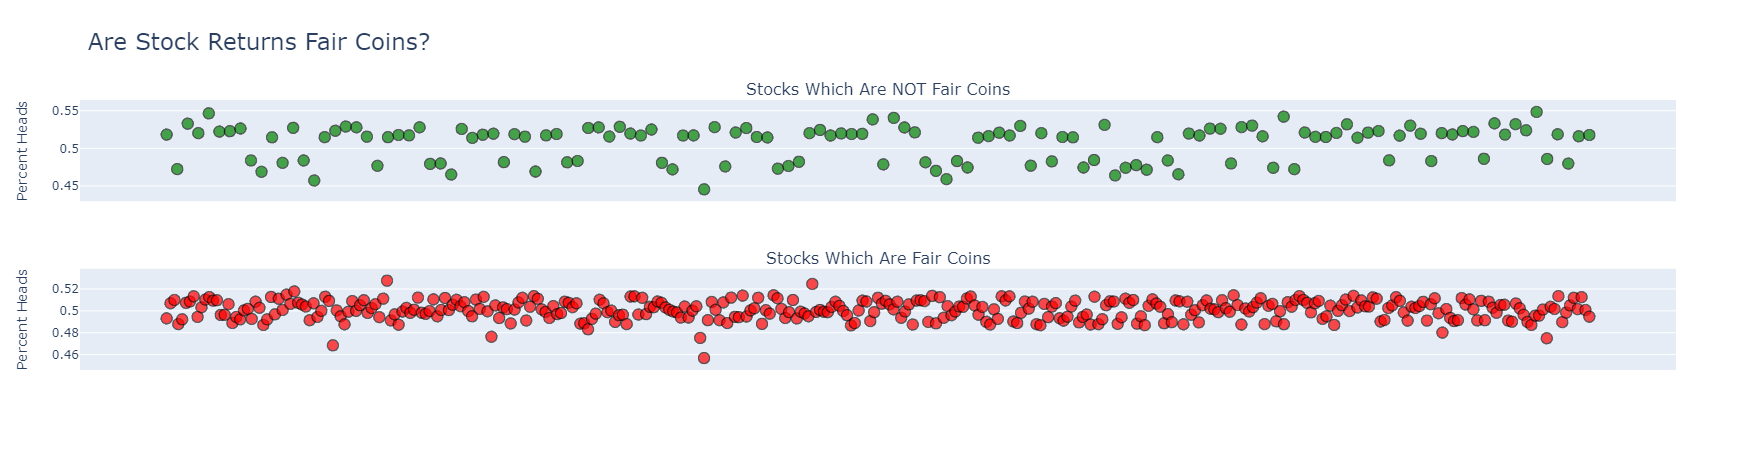

In [32]:
reject_null = all_data_basic[all_data_basic['symbol'].isin(stocks_which_reject_null)].groupby(by='symbol')['as_coin_flip'].mean().reset_index()
fail_to_reject_null = all_data_basic[all_data_basic['symbol'].isin(stocks_which_fail_to_reject_null)].groupby(by='symbol')['as_coin_flip'].mean().reset_index()

fig = make_subplots(rows=2, cols=1,
                   subplot_titles=('Stocks Which Are NOT Fair Coins',
                                   'Stocks Which Are Fair Coins'))

# Add traces
fig.add_trace(go.Scatter(x=reject_null['symbol'], 
                         y=reject_null['as_coin_flip'],
                         mode='markers',
                         hoverinfo='x',
                         marker=dict(color='green',size=11, opacity=.7, line=dict(color='black', width=1))), row=1, col=1)

fig.add_trace(go.Scatter(x=fail_to_reject_null['symbol'], 
                         y=fail_to_reject_null['as_coin_flip'],
                         mode='markers',
                         hoverinfo='x',
                         marker=dict(color='red',size=11, opacity=.7, line=dict(color='black', width=1)),showlegend=False), row=2, col=1)

fig.update_layout(showlegend=False)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=2, col=1)
fig.update_yaxes(title='Percent Heads')

fig.update_layout(title='Are Stock Returns Fair Coins?',
                 title_font=dict(size=23))
fig.show()

In [12]:
#creating a new feature that will allow us to narrow things down by year
all_data_basic['date'] = pd.to_datetime(all_data_basic['date'], infer_datetime_format=True)
all_data_basic['year'] = all_data_basic['date'].dt.year

In [13]:
new_df = pd.DataFrame({'symbol':[], 'date':[], 'pvalue':[]})

for stock in set(all_data_basic['symbol']):
    for year in set(all_data_basic[all_data_basic['symbol'] == stock]['year']):
        y = all_data_basic[(all_data_basic['symbol'] == stock) & (all_data_basic['year'] == year)]['as_coin_flip']
        tstat, pvalue = ttest_1samp(y, .5)
        test_df = pd.DataFrame({'symbol':[stock], 'date':[year], 'pvalue':[pvalue]})
        new_df = new_df.append(test_df)

In [14]:
control_bar_df = pd.DataFrame({'year':[], 'pvalue':[]})

for year in set(all_data_basic['year']):
    
    y = all_data_basic[all_data_basic['year'] == year]['as_coin_flip']
    tstat, pvalue = ttest_1samp(y, .5)
    
    temp_df = pd.DataFrame({'year':[year], 'pvalue':[pvalue]})
 
    control_bar_df = control_bar_df.append(temp_df)
    

In [15]:
control_mean = all_data_basic.groupby(by='year')['as_coin_flip'].mean()
control = pd.merge(control_bar_df, control_mean, how='inner', on='year')
control

,year,pvalue,as_coin_flip
0,2000.0,3.882010e-12,0.488047
1,2001.0,2.423362e-108,0.465239
2,2002.0,1.404882e-157,0.458802
3,2003.0,2.190436e-05,0.506513
4,2004.0,4.679085e-03,0.504319
5,2005.0,5.882736e-30,0.482740
6,2006.0,1.196955e-05,0.506577
7,2007.0,4.854190e-02,0.497057
8,2008.0,2.140065e-26,0.484306
9,2009.0,1.337041e-14,0.511362


In [16]:
percent_df = pd.DataFrame({'symbol':[], 'percent':[]})
for stock in set(new_df['symbol']):
    i=0
    for each in new_df[new_df['symbol'] == stock]['pvalue']:
        if each < .05:
            i += 1
    percent = i / len(new_df['pvalue'])
    alpha_df = pd.DataFrame({'symbol':[stock], 'percent':[percent]})
    percent_df = percent_df.append(alpha_df)

In [17]:
#creating the top pie chart
i = 0
for each in new_df['pvalue']:
    if each < .05:
        i += 1
top_coin_percentage = i / len(new_df['pvalue'])

In [19]:
#creating the bottom pie chart
i = 0
for each in control['pvalue']:
    if each < .05:
        i += 1
bottom_coin_percentage = i / len(control['pvalue'])

In [20]:
years_which_reject_null = []
years_which_fail_to_reject_null = []

for i in range(len(control['pvalue'])):
    if control.loc[i][1] > .05:
        years_which_fail_to_reject_null.append(control.loc[i][0])
    else:
        years_which_reject_null.append(control.loc[i][0])

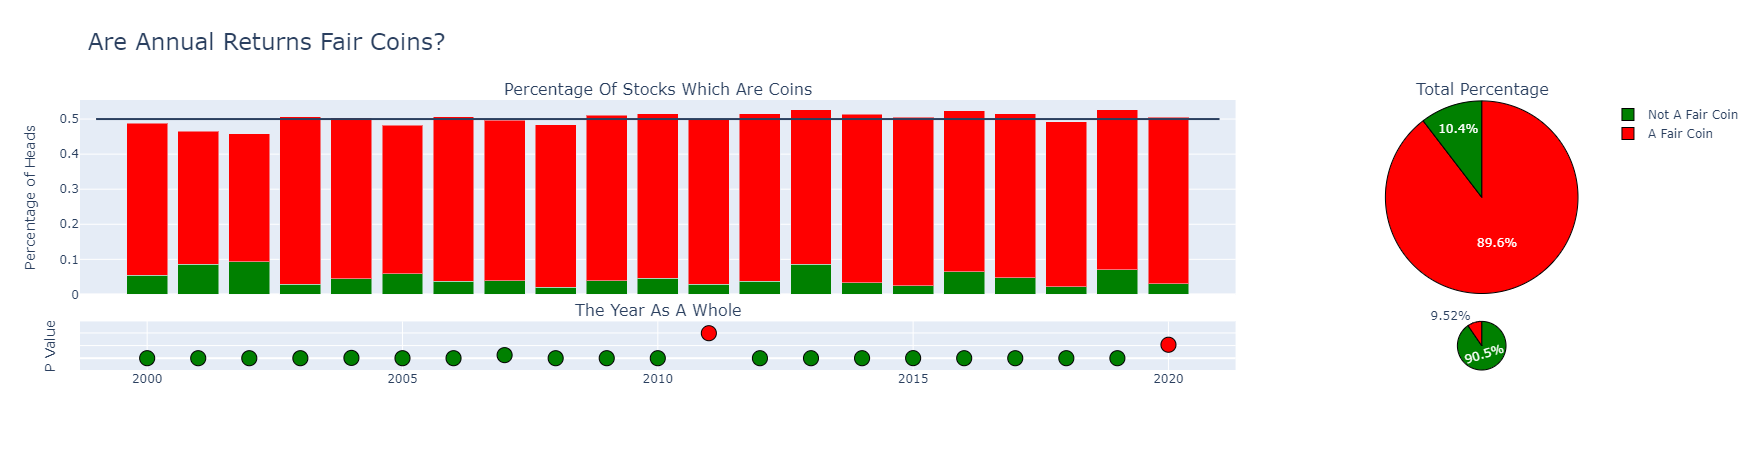

In [40]:
top_labels = ['Not A Fair Coin', 'A Fair Coin']
top_values = [top_coin_percentage, 1 - top_coin_percentage]

bottom_labels = ['Not A Fair Coin', 'A Fair Coin']
bottom_values = [bottom_coin_percentage, 1 - bottom_coin_percentage]



top = percent_df[percent_df['symbol'].isin(stocks_which_reject_null)]
bottom = percent_df[percent_df['symbol'].isin(stocks_which_fail_to_reject_null)]

fig = make_subplots(rows=2, cols=2,
                   specs=[[{'type':'bar'}, {'type':'domain'}],
                         [{'type':'scatter'},{'type':'domain'}]],
                    horizontal_spacing=.1,
                    vertical_spacing=.1,
                   subplot_titles=['Percentage Of Stocks Which Are Coins', 'Total Percentage', 'The Year As A Whole'],
                    shared_xaxes=True,
                    row_heights=[4, 1],
                   column_widths=[0.6, .1])

fig.add_trace(
    go.Pie(labels=top_labels, values=top_values,
          marker=dict(colors=['green', 'red'], line=dict(color='black', width=1))),
            1, 2)

#the control pie chart
fig.add_trace(
    go.Pie(labels=bottom_labels, values=bottom_values,
          marker=dict(colors=['green', 'red'], line=dict(color='black', width=1))),
           2, 2)

fig.add_trace(
    go.Bar(x=bar_chart['year'], y=bar_chart['reject'], marker_color='green', hovertext=round(bar_chart['test'], 3) * 100, hoverinfo='text', showlegend=False), 1, 1)

fig.add_trace(
    go.Bar(x=bar_chart['year'], y=bar_chart['fail_to_reject'], marker_color='red', hovertext=round(1 - bar_chart['test'], 3) * 100, hoverinfo='text', showlegend=False), 1, 1)

fig.add_shape(type='line', x0=1999, y0=.5, x1=2021, y1=.5, row=1, col=1)
#the control scatter plot
fail_to_reject = control[control['year'].isin(years_which_fail_to_reject_null)]
fig.add_trace(
    go.Scatter(x=fail_to_reject['year'], y=fail_to_reject['pvalue'],
              mode='markers',
               hoverinfo='y',
               showlegend=False,
              marker=dict(color='red',size=15, line=dict(color='black', width=1))), 2, 1)

reject = control[control['year'].isin(years_which_reject_null)]
fig.add_trace(
    go.Scatter(x=reject['year'], y=reject['pvalue'],
              mode='markers',
               hoverinfo='y',
               showlegend=False,
              marker=dict(color='green',size=15, line=dict(color='black', width=1))), 2, 1)

#fig.update_layout(showlegend=False)
fig.update_layout(barmode='stack')
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_yaxes(title='Percentage of Heads', row=1, col=1)
fig.update_yaxes(title='P Value', showticklabels=False, row=2, col=1 )
fig.update_layout(title='Are Annual Returns Fair Coins?',
                 title_font=dict(size=23))

fig.show()

In [22]:
stock_annual_mean_df = pd.DataFrame({'symbol':[], 'year':[], 'as_coin_flip':[]})

for stock in set(all_data_basic['symbol']):
    annual_mean = all_data_basic[all_data_basic['symbol'] == stock].groupby(by='year')['as_coin_flip'].mean().reset_index()
    annual_mean['symbol'] = stock
    stock_annual_mean_df = stock_annual_mean_df.append(annual_mean)

In [23]:
new_df['test'] = new_df['pvalue']
new_df['test'] = new_df['test'].apply(lambda x: 1 if x < .05 else 0)
annual_percent_reject_null = (new_df.groupby(by='date')['test'].sum() / len(set(new_df['symbol']))).reset_index()

In [24]:
total_percent_reject_null = new_df['test'].mean()
total_percent_reject_null

0.10407193054981398

In [25]:
annual_percent_reject_null.columns = ['year', 'test']
annual_percent_reject_null

,year,test
0,2000.0,0.110891
1,2001.0,0.186139
2,2002.0,0.203960
3,2003.0,0.057426
4,2004.0,0.087129
5,2005.0,0.120792
6,2006.0,0.073267
7,2007.0,0.079208
8,2008.0,0.043564
9,2009.0,0.077228


In [27]:
bar_chart = pd.merge(control, annual_percent_reject_null, on='year', how='inner')
bar_chart['reject'] = bar_chart['as_coin_flip'] * bar_chart['test']
bar_chart['fail_to_reject'] = bar_chart['as_coin_flip'] * (1 - bar_chart['test'])
bar_chart

,year,pvalue,as_coin_flip,test,reject,fail_to_reject
0,2000.0,3.882010e-12,0.488047,0.110891,0.054120,0.433927
1,2001.0,2.423362e-108,0.465239,0.186139,0.086599,0.378640
2,2002.0,1.404882e-157,0.458802,0.203960,0.093578,0.365225
3,2003.0,2.190436e-05,0.506513,0.057426,0.029087,0.477426
4,2004.0,4.679085e-03,0.504319,0.087129,0.043941,0.460379
5,2005.0,5.882736e-30,0.482740,0.120792,0.058311,0.424429
6,2006.0,1.196955e-05,0.506577,0.073267,0.037116,0.469462
7,2007.0,4.854190e-02,0.497057,0.079208,0.039371,0.457686
8,2008.0,2.140065e-26,0.484306,0.043564,0.021098,0.463208
9,2009.0,1.337041e-14,0.511362,0.077228,0.039491,0.471871
